In [1]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier

In [3]:
df = pd.read_excel('NASA_data_set.xlsx')
df = df.drop(columns=[
    "koi_teq_err1","koi_score","koi_teq_err2",
    "kepler_name","dec","ra","koi_teq","koi_insol",
    "koi_tce_delivname","koi_period_err1","koi_tce_plnt_num","koi_period_err2",
    "koi_time0bk_err1","koi_time0bk_err2","koi_impact_err1","koi_impact_err2",
    "koi_duration_err1","koi_duration_err2","koi_depth_err1","koi_depth_err2",
    "koi_prad_err1","koi_prad_err2","koi_insol_err1","koi_insol_err2",
    "koi_steff_err1","koi_steff_err2","koi_slogg_err1","koi_slogg_err2",
    "koi_srad_err1","koi_srad_err2","koi_pdisposition",
    "koi_fpflag_nt","koi_fpflag_ss","koi_fpflag_co","koi_fpflag_ec"
])

df.head()

,kepid,kepoi_name,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,10797460,K00752.01,CONFIRMED,9.488036,170.538750,0.146,2.95750,615.8,2.26,35.8,5455.0,4.467,0.927,15.347
1,10797460,K00752.02,CONFIRMED,54.418383,162.513840,0.586,4.50700,874.8,2.83,25.8,5455.0,4.467,0.927,15.347
2,10811496,K00753.01,CANDIDATE,19.899140,175.850252,0.969,1.78220,10829.0,14.60,76.3,5853.0,4.544,0.868,15.436
3,10848459,K00754.01,FALSE POSITIVE,1.736952,170.307565,1.276,2.40641,8079.2,33.46,505.6,5805.0,4.564,0.791,15.597
4,10854555,K00755.01,CONFIRMED,2.525592,171.595550,0.701,1.65450,603.3,2.75,40.9,6031.0,4.438,1.046,15.509


In [4]:
candidates_df = df[df['koi_disposition'] == 'CANDIDATE'].copy()

# Create the training dataset using only labeled data
train_df = df[df['koi_disposition'] != 'CANDIDATE'].copy()

print(f"Training data size: {len(train_df)}")
print(f"Candidate data size for final prediction: {len(candidates_df)}")

Training data size: 7585
Candidate data size for final prediction: 1979


In [5]:
candidate_identifiers = candidates_df[['kepid', 'kepoi_name']].copy()

In [6]:
df.columns = df.columns.str.strip()

In [7]:
train_df['koi_disposition'] = train_df['koi_disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

In [8]:
features_to_drop = [
    'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
    'koi_pdisposition'
]

In [9]:
# safer dropping
drop_cols = [col for col in features_to_drop if col in train_df.columns]

y = train_df['koi_disposition']
X = train_df.drop(columns=drop_cols)

In [10]:
X_candidates = candidates_df.drop(columns=drop_cols)

In [11]:
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        # Assign the filled column back to avoid FutureWarning
        X[col] = X[col].fillna(median_val)
        X_candidates[col] = X_candidates[col].fillna(median_val)

print("Preprocessing complete. No missing values remain.")

Preprocessing complete. No missing values remain.


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25, # 25% for validation
    random_state=42,
    stratify=y
)

In [13]:
X_candidates = X_candidates[X_train.columns]

In [14]:
model = CatBoostClassifier(random_state=42, verbose=0, iterations=500)

# Train the model on the training data
model.fit(X_train, y_train)


--- Evaluating Model Performance on Validation Set ---
Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.95      0.94      0.95      1210
     CONFIRMED       0.90      0.92      0.91       687

      accuracy                           0.93      1897
     macro avg       0.93      0.93      0.93      1897
  weighted avg       0.93      0.93      0.93      1897

Confusion Matrix:


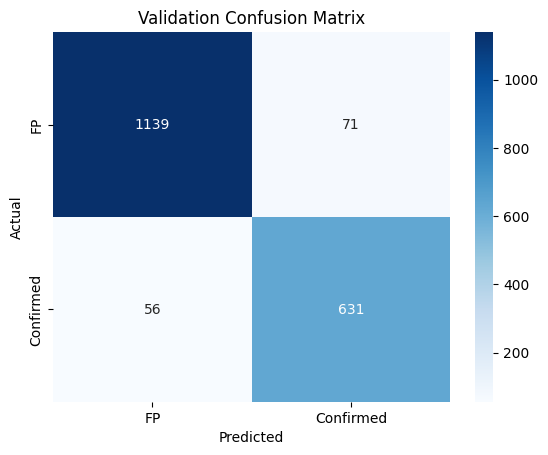

In [15]:
print("\n--- Evaluating Model Performance on Validation Set ---")

# Make predictions on the unseen validation data
y_pred = model.predict(X_val)

# Print the classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['FALSE POSITIVE', 'CONFIRMED']))


# Display a more visual confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FP', 'Confirmed'], yticklabels=['FP', 'Confirmed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

In [16]:
candidate_predictions = model.predict(X_candidates)

# Get the probability scores (how confident the model is)
candidate_probabilities = model.predict_proba(X_candidates)[:, 1]  # Probability of being 'CONFIRMED'

# Apply custom classification thresholds
custom_labels = []
for prob in candidate_probabilities:
    if 0.5 <= prob < 0.75:
        custom_labels.append("Planetary Candidate")
    elif 0.75 <= prob <= 1.0:
        custom_labels.append("Confirmed")
    else:
        custom_labels.append("Below Threshold")

In [17]:
# Updated cell: build results DataFrame with custom thresholds and keep id/name columns
results_df = candidate_identifiers.copy()

results_df['predicted_disposition'] = [
    "Planetary Candidate" if 0.5 <= prob < 0.75
    else "Confirmed" if prob >= 0.75
    else "FALSE POSITIVE"
    for prob in candidate_probabilities
]

results_df['probability_confirmed'] = candidate_probabilities

# Rename id/name columns for clarity and reorder to show id & name first
results_df = results_df.rename(columns={'kepid': 'id', 'kepoi_name': 'name'})
results_df = results_df[['id', 'name', 'predicted_disposition', 'probability_confirmed']]


In [18]:
results_df.head(20)

,id,name,predicted_disposition,probability_confirmed
2,10811496,K00753.01,FALSE POSITIVE,0.077739
58,11818800,K00777.01,FALSE POSITIVE,0.371560
62,11918099,K00780.02,FALSE POSITIVE,0.414326
63,9579641,K00115.03,FALSE POSITIVE,0.106375
84,3115833,K00797.01,FALSE POSITIVE,0.190706
92,3453214,K00802.01,FALSE POSITIVE,0.456203
112,4544670,K00815.01,FALSE POSITIVE,0.317034
118,4936180,K00820.01,FALSE POSITIVE,0.000076
123,5115978,K00823.01,FALSE POSITIVE,0.002613
166,6867155,K00868.01,FALSE POSITIVE,0.473179


In [ ]:
results_df.to_csv('candidate_names_planet_predictions.csv', index=False)

In [ ]:
# Save the model
model.save_model("catboost_model.cbm")

In [ ]:
#To Load it later
#from catboost import CatBoostClassifier
#loaded_model = CatBoostClassifier()
#loaded_model.load_model("catboost_model.cbm")

In [22]:
print("--- Overfitting Analysis ---")

# 1. Get the accuracy on the TRAINING data (data the model has seen)
train_accuracy = model.score(X_train, y_train)

# 2. Get the accuracy on the VALIDATION data (unseen data)
validation_accuracy = model.score(X_val, y_val)

print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy:.2%})")
print(f"Validation Accuracy: {validation_accuracy:.4f} ({validation_accuracy:.2%})")
print("-" * 30)

# 3. Analyze the difference
difference = train_accuracy - validation_accuracy
if difference > 0.1:
    print(f"🚨 Potential Overfitting Detected! The difference is {difference:.2%}.")
elif difference < 0:
    print("Warning: Validation accuracy is higher than training accuracy. This is unusual but can happen with small datasets.")
else:
    print("✅ Model seems to have a good fit. The performance is consistent.")

--- Overfitting Analysis ---
Training Accuracy:   0.9764 (97.64%)
Validation Accuracy: 0.9331 (93.31%)
------------------------------
✅ Model seems to have a good fit. The performance is consistent.
